In [2]:
import io

import requests






import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import *

# device = K.utils.get_cuda_or_mps_device_if_available()
device = torch.device("cpu")

img1 = K.io.load_image("n01558993_robin.JPEG", K.io.ImageLoadType.RGB32, device=device)[None, ...]






In [3]:
sift_feature = KF.SIFTFeature(8000, True).eval().to(device)
#feature = KF.SIFTFeatureScaleSpace(100, True).eval().to(device)

keynet_feature = KF.KeyNetAffNetHardNet(5000, True).eval().to(device)
#feature = KF.KeyNetAffNetHardNet(10, True).eval().to(device)


input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    # "image1": K.color.rgb_to_grayscale(img2),
}

hw1 = torch.tensor(img1.shape[2:])
hw2 = torch.tensor(img1.shape[2:])

adalam_config = {"device": device}

input_dict["image0"].size()

hw1.size()

with torch.inference_mode():
    lafs_sift, resps_sift, descs_sift = sift_feature(K.color.rgb_to_grayscale(img1))
    lafs_keynet, resps_keynet, descs_keynet = keynet_feature(K.color.rgb_to_grayscale(img1))
    
    print(K.color.rgb_to_grayscale(img1).shape)
    
 

torch.Size([1, 1, 375, 500])


In [8]:
from get_patch_and_feature import get_laf_scale_and_angle, get_laf_center

ModuleNotFoundError: No module named 'get_patch_and_feature'

In [103]:
    
    
import   math

cos = torch.cos
sin = torch.sin
tan = torch.tan
deg2rad = torch.deg2rad
rad2deg = torch.rad2deg

concatenate = torch.cat
def scale_laf(laf, scale_coef) :
    """Multiplies region part of LAF ([:, :, :2, :2]) by a scale_coefficient.

    So the center, shape and orientation of the local feature stays the same, but the region area changes.

    Args:
        LAF :math:`(B, N, 2, 3)`
        scale_coef: broadcastable tensor or float.

    Returns:
        LAF :math:`(B, N, 2, 3)`

    Example:
        >>> input = torch.ones(1, 5, 2, 3)  # BxNx2x3
        >>> scale = 0.5
        >>> output = scale_laf(input, scale)  # BxNx2x3
    """
    # if not isinstance(scale_coef, (float, Tensor)):
    #     raise TypeError(f"scale_coef should be float or Tensor. Got {type(scale_coef)}")
    centerless_laf = laf[:, :, :2, :2]
    return concatenate([scale_coef * centerless_laf, laf[:, :, :, 2:]], dim=3)



def visualize_LAF_axis_oval(img, LAF, img_idx = 0, color='r', linewidth=1,
                  draw_ori = True, fig=None,
                  ax = None, return_fig_ax = False, **kwargs):
    from kornia_moons.feature import to_numpy_image
    x, y = get_laf_pts_to_draw(scale_laf(LAF, 0.5), img_idx)
    if not draw_ori:
        x= x[1:]
        y= y[1:]
    if (fig is None and ax is None):
        fig, ax = plt.subplots(1,1, **kwargs)
    if (fig is not None and ax is None):
        ax = fig.add_axes([0, 0, 1, 1])
    
    ax.imshow(to_numpy_image(img[img_idx]))
    
    temp_eig,temp_V,temp_angle=get_laf_scale_and_angle(LAF)
    temp_center=get_laf_center(LAF)



    
    
    ax.plot(x, y, color, linewidth=linewidth)
    
    for p in range(LAF.shape[1]):
        major_axis=torch.matmul( LAF[0,p,:,0:2] /2  ,temp_V[0,p,0,0:2])
        temp1=torch.linspace( 0, major_axis[0],3 )
        temp2=torch.linspace( 0, major_axis[1],3 )


        plt.plot(temp1+temp_center[0,p,0],temp2+temp_center[0,p,1] ,'r')
    
    if return_fig_ax : return fig, ax
    return


def get_laf_pts_to_draw(LAF, img_idx: int = 0):
    """Returns list for drawing LAFs (local features).

    Args:
        LAF: :math:`(B, N, 2, 3)`
        n_pts: number of points to output.

    Returns:
        List of boundary points x, y`

    Examples:
        x, y = get_laf_pts_to_draw(LAF, img_idx)
        plt.figure()
        plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
        plt.plot(x, y, 'r')
        plt.show()
    """
    # TODO: Refactor doctest

    pts = laf_to_boundary_points(LAF[img_idx : img_idx + 1])[0]
    # LAF[img_idx : img_idx + 1] has the same dimension as LAF
    pts_np = pts.detach().permute(1, 0, 2).cpu()
    return (pts_np[..., 0].tolist(), pts_np[..., 1].tolist())


def laf_to_boundary_points(LAF, n_pts: int = 50) :
    """Convert LAFs to boundary points of the regions + center.

    Used for local features visualization, see visualize_laf function.

    Args:
        LAF: :math:`(B, N, 2, 3)`
        n_pts: number of points to output.

    Returns:
        tensor of boundary points LAF: :math:`(B, N, n_pts, 2)`
    """

    B, N, _, _ = LAF.size()
    pts = concatenate(
        [
            sin(torch.linspace(0, 2 * math.pi, n_pts )).unsqueeze(-1),
            cos(torch.linspace(0, 2 * math.pi, n_pts )).unsqueeze(-1),
            torch.ones(n_pts , 1),
        ],
        dim=1,
    )
    # Add origin to draw also the orientation
    pts =  pts.unsqueeze(0).expand(B * N, n_pts, 3)
    pts = pts.to(LAF.device).to(LAF.dtype)

    # aux = tensor([0.0, 0.0, 1.0]).view(1, 1, 3).expand(B * N, 1, 3)
    # HLAF = concatenate([LAF.view(-1, 2, 3), aux.to(LAF.device).to(LAF.dtype)], dim=1)
    HLAF =LAF.view(-1, 2, 3)

    # HLAF: dimension:(:,2,3)           pts.permute(0, 2, 1) has dimension (:,3,n_pts)
    # bmm ouptput: (:,2,n_pts)
    #bmm:
    # input = torch.randn(10, 3, 4)
#     >>> mat2 = torch.randn(10, 4, 5)
# >>> res = torch.bmm(input, mat2)
# >>> res.size()
# torch.Size([10, 3, 5])

    pts_h = torch.bmm(HLAF, pts.permute(0, 2, 1))

    pts_h=pts_h.permute(0, 2, 1)

    # return convert_points_from_homogeneous(pts_h.view(B, N, n_pts, 3))
    return pts_h.view(B, N, n_pts, 2)







In [104]:
import torchvision
def get_resized_patch(img,angle,position,len_major,len_minor,size=[16,16]):
    
    """Return a resize(distorted) patch of given size.

    Args:
        img: :`(1, 3, size 1 of img, size 2 of img)`
        angle : 'float' (not tensor), in degree instead of rad
        position: tensor (1 dimensional) of length 2, center of the oval/unresized patch
        len_major: the length of the major axis of the oval
        len_minor: the length of the minor axis of the oval
        size: list of length 2, the size of the desired resized patch, e.g.[16,16]
        

    Returns:
        resized_patch: [size[0],size[1],3]

        
    """
    rotated_img=torchvision.transforms.functional.rotate(img,angle)

    # Image center (e.g., center of rotation)
    cx, cy = img.shape[2]/2, img.shape[3]/2

    # Get the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    rotation_matrix=torch.from_numpy(rotation_matrix)
    rotation_matrix=rotation_matrix.to(torch.float)

    # adding 1 dimension renders [x,y] --> [x,y,1]
    # original_point=torch.cat([temp_center[0,p,:],torch.ones_like(temp_center[0,p,0:1])])
    original_point=torch.cat([position,torch.ones_like(position[0:1])])
    original_point=original_point.unsqueeze(-1)

    # Calculate the new position by multiplying the rotation matrix
    new_point = torch.matmul(rotation_matrix, original_point)
    new_x, new_y = new_point[0,:], new_point[1,:]
    
    temp=torch.zeros([rotated_img.shape[0],rotated_img.shape[1],2*rotated_img.shape[2],2*rotated_img.shape[3] ])
    temp[:,:,0:rotated_img.shape[2],0:rotated_img.shape[3]]=rotated_img
    
    rotated_img=temp


    patch=rotated_img[:,:,
                    torch.max(torch.cat([new_y-len_minor,torch.tensor([0]) ]) ) .ceil().to(torch.int): 
                    torch.min( torch.cat([new_y+len_minor,torch.tensor( rotated_img.shape[3:4]) ]) ).floor().to(torch.int),
                    torch.max(torch.cat([new_x-len_major,torch.tensor([0]) ]) ).ceil().to(torch.int): 
                    torch.min( torch.cat([new_x+len_major,torch.tensor( rotated_img.shape[2:3]) ]) ).floor().to(torch.int) 
                    ]    # the first two dimensions of patch match the single input img, which is [1,3,:,:]



    patch=patch.permute(2,3,1,0)
    patch=patch.squeeze(-1)  # the dimension of patch is [:,:,3]
    
    if patch.shape[1]<1:
        print( torch.max(torch.cat([new_y-len_minor,torch.tensor([0]) ]) ) .ceil().to(torch.int)  )
        print(  torch.min( torch.cat([new_y+len_minor,torch.tensor( rotated_img.shape[3:4]) ]) ).floor().to(torch.int)  )
        print( torch.max(torch.cat([new_x-len_major,torch.tensor([0]) ]) ).ceil().to(torch.int) )
        print( torch.min( torch.cat([new_x+len_major,torch.tensor( rotated_img.shape[2:3]) ]) ).floor().to(torch.int)  )
        print(patch.shape)
        print(len_major)
        print(new_x-len_major)
        print(new_x+len_major)
        print(torch.tensor( rotated_img.shape[2:3]))
    
    


    patch_resize=torchvision.transforms.functional.resize(patch.permute(2,0,1), size)
    
    
    patch_resize=patch_resize.permute(1,2,0) # the dimension of patch is [70,70,3]
    # plt.imshow(p)
    return patch_resize,patch


from PIL import Image
# func to show_images
def show_images(images,save_path=None, **kwargs):
    plt.figure(figsize=(10, 10), dpi=80)
    print(images.shape)
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    ndarr = (ndarr * 255).clip(0, 255).astype('uint8')
    print(ndarr.shape)
    im = Image.fromarray(ndarr)
    plt.imshow(im)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        print(f"Image saved to {save_path}")
    plt.show()
    

This part is for SIFT

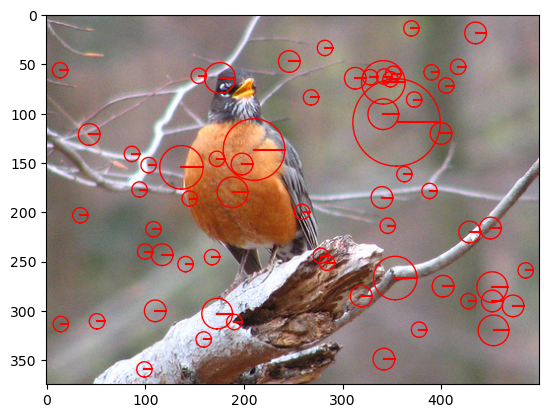

In [105]:
import random
# n = 100  # Number of random items you want to pick
# items = random.sample(range(lafs_sift.shape[1]), n)

n=64
items=np.linspace(0,lafs_sift.shape[1]-1,n, dtype=int)
visualize_LAF_axis_oval(img1, lafs_sift[:,torch.tensor(items),:,:])


plt.savefig('sift_feature.png', bbox_inches='tight', pad_inches=0)


torch.Size([64, 3, 16, 16])
(146, 146, 3)
Image saved to sift_tokens.png


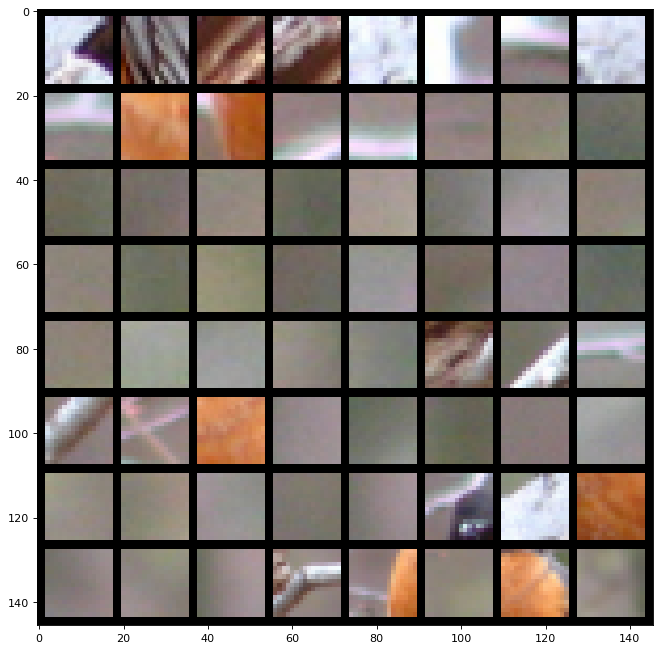

In [106]:
    
# need tensor of shape (B,3,wideth,height)
size=[16,16]
size_original=0.5
tokens=torch.zeros([n,3,size[0],size[1]])
lafs=lafs_sift[:,torch.tensor(items),:,:]



img=img1
temp_eig,temp_V,temp_angle=get_laf_scale_and_angle(lafs)  
temp_center=get_laf_center(lafs)   
        # use size_patch to control the size of original patch
            
token_from_img=[]

for p in range(lafs.shape[1]):
    angle = temp_angle[0,p,0].float().item()
    position=temp_center[0,p,:]
    len_major=temp_eig[0,p,0]*size_original
    len_minor=temp_eig[0,p,1]*size_original

    temp_resized_patch,patch=get_resized_patch(img,angle,position,len_major,len_minor,size)
    # plt.imshow(temp_resized_patch)
    tokens[p,:,:,:]=temp_resized_patch.permute(2,0,1)
        

# plt.imshow(tokens[10,:,:,:].permute(1,2,0))
show_images(tokens,save_path='sift_tokens.png')

The following is for KeyNet  

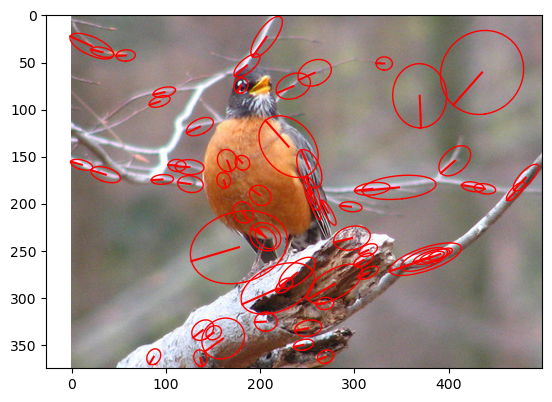

In [107]:
import random
# n = 100  # Number of random items you want to pick
# items = random.sample(range(lafs_keynet.shape[1]), n)
n=64
items=np.linspace(0,lafs_keynet.shape[1]-1,n, dtype=int)
visualize_LAF_axis_oval(img1, lafs_keynet[:,torch.tensor(items),:,:])

plt.savefig('keynet_feature.png', bbox_inches='tight', pad_inches=0)

torch.Size([64, 3, 16, 16])
(146, 146, 3)
Image saved to keynet_tokens.png


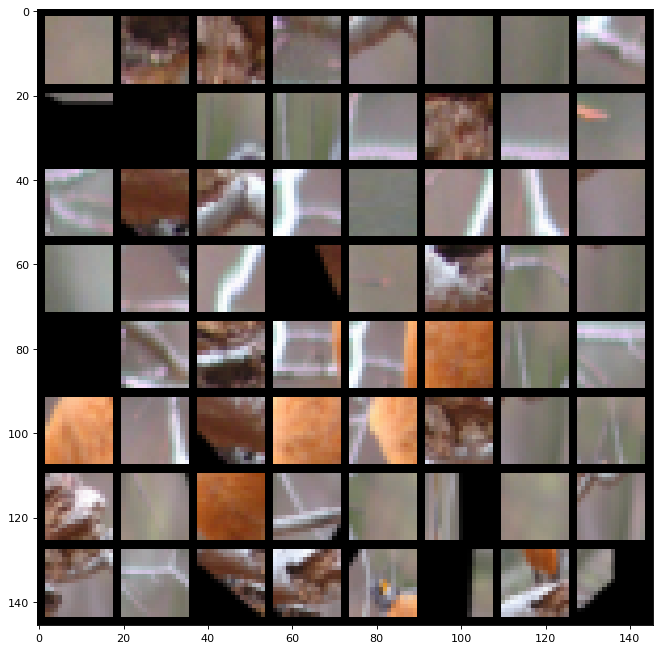

In [108]:
    
# need tensor of shape (B,3,wideth,height)
size=[16,16]
size_original=1
tokens=torch.zeros([n,3,size[0],size[1]])
lafs=lafs_keynet[:,torch.tensor(items),:,:]



img=img1
temp_eig,temp_V,temp_angle=get_laf_scale_and_angle(lafs)  
temp_center=get_laf_center(lafs)   
        # use size_patch to control the size of original patch
            
token_from_img=[]

for p in range(lafs.shape[1]):
    angle = temp_angle[0,p,0].float().item()
    position=temp_center[0,p,:]
    len_major=temp_eig[0,p,0]*size_original
    len_minor=temp_eig[0,p,1]*size_original

    temp_resized_patch,patch=get_resized_patch(img,angle,position,len_major,len_minor,size)
    tokens[p,:,:,:]=temp_resized_patch.permute(2,0,1)
        
# plt.imshow(tokens[1,:,:,:].permute(1,2,0))


show_images(tokens,save_path='keynet_tokens.png')



test for "affine_grid" and " grid_sample"



the size of selected LAF: torch.Size([64, 2, 3])
torch.Size([1, 3, 375, 500])
torch.Size([1, 3, 375, 500])
torch.Size([64, 3, 375, 500])
the size of input: torch.Size([64, 3, 375, 500])
the size of grid: torch.Size([64, 24, 24, 2])
torch.Size([3, 24, 24])
tensor([[[[163.5538,  63.0345],
          [164.7899,  62.6971],
          [166.0259,  62.3596],
          ...,
          [189.5108,  55.9476],
          [190.7469,  55.6101],
          [191.9829,  55.2727]],

         [[163.7159,  64.3510],
          [164.9520,  64.0135],
          [166.1880,  63.6760],
          ...,
          [189.6729,  57.2640],
          [190.9090,  56.9266],
          [192.1450,  56.5891]],

         [[163.8780,  65.6674],
          [165.1140,  65.3299],
          [166.3501,  64.9924],
          ...,
          [189.8350,  58.5805],
          [191.0710,  58.2430],
          [192.3071,  57.9055]],

         ...,

         [[166.9574,  90.6794],
          [168.1935,  90.3419],
          [169.4295,  90.0045],
      

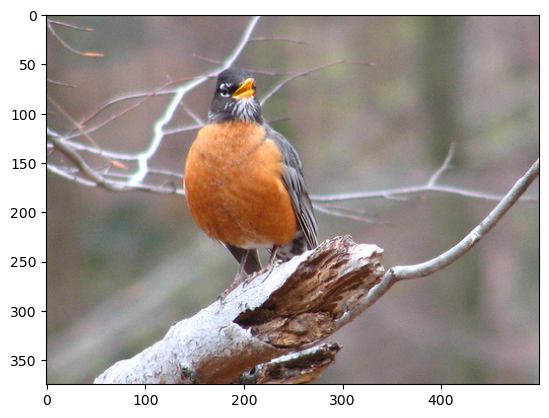

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
selected_laf=lafs
selected_laf=selected_laf.squeeze(0)

# selected_laf[5]=torch.zeros_like(selected_laf[0])

print(f"the size of selected LAF: {selected_laf.shape}")
print(img1.shape)


test_image=img_temp.repeat(selected_laf.shape[0],1,1,1)
print(test_image.shape)
# grid = F.affine_grid(selected_laf, test_image.size())
grid = F.affine_grid(selected_laf,torch.Size((test_image.shape[0], 3, 24, 24)),align_corners = False)

print(f"the size of input: {test_image.shape}")
print(f"the size of grid: {grid.shape}")




x = F.grid_sample(input=test_image, grid=grid,mode='nearest')

print(x[20].shape)
plt.imshow(test_image[20].permute(1,2,0))

print(grid)



tensor([[[[-0.1277, -0.7479],
          [-0.1211, -0.7492],
          [-0.1145, -0.7506],
          ...,
          [ 0.0107, -0.7762],
          [ 0.0173, -0.7776],
          [ 0.0239, -0.7789]],

         [[-0.1268, -0.7426],
          [-0.1203, -0.7439],
          [-0.1137, -0.7453],
          ...,
          [ 0.0116, -0.7709],
          [ 0.0182, -0.7723],
          [ 0.0248, -0.7736]],

         [[-0.1260, -0.7373],
          [-0.1194, -0.7387],
          [-0.1128, -0.7400],
          ...,
          [ 0.0125, -0.7657],
          [ 0.0190, -0.7670],
          [ 0.0256, -0.7684]],

         ...,

         [[-0.1096, -0.6373],
          [-0.1030, -0.6386],
          [-0.0964, -0.6400],
          ...,
          [ 0.0289, -0.6656],
          [ 0.0355, -0.6670],
          [ 0.0421, -0.6683]],

         [[-0.1087, -0.6320],
          [-0.1021, -0.6334],
          [-0.0955, -0.6347],
          ...,
          [ 0.0297, -0.6604],
          [ 0.0363, -0.6617],
          [ 0.0429, -0.6631]],



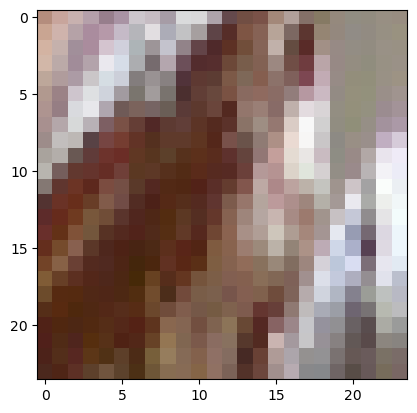

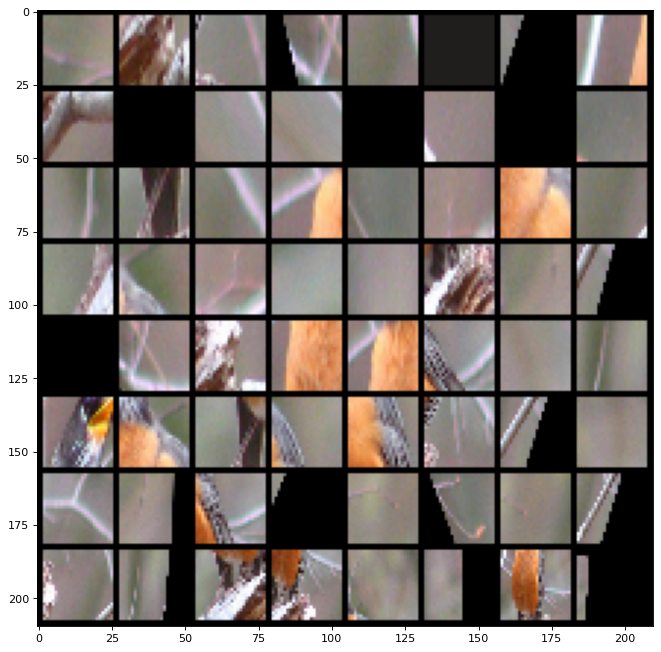

In [113]:
temp1=torch.tensor([test_image.shape[-2],test_image.shape[-1]])/2
temp1=temp1.view(1,1,1,2)
grid_normalized=grid/temp1
grid_normalized=grid_normalized-torch.tensor([1,1]).view(1,1,1,2)

x = F.grid_sample(input=test_image, grid=grid_normalized,mode='bilinear')

print(grid_normalized)

print(x[1].permute(1,2,0))
plt.imshow(x[1].permute(1,2,0))
# plt.imshow(x[21].permute(1,2,0))
show_images(x)
